In [ ]:
!pip install yfinance
!pip install torchsummaryX
!pip install wandb -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import yfinance as yf
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchsummaryX import summary
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content'

In [ ]:
import wandb
wandb.login(key="03916b709446813b51f72a1b29a2854a9dd9e3f7")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Training Config
config = {
    "batch_size" : 32,
    "lr" : 1e-3,
    "epochs" : 100,
    "look_back" : 60,
    "feature_dim" : 4,
    "hidden_dim" : 64,
    "output_dim" : 1,
    "num_layers" : 3,
    "dropout" : 0.2
}

In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
                     'Log Adj Close', 'Log Return', 'Log Volume', 'Log Volume Chg', 'Log Range', '10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * self.scaling_factor
        data["Log Volume"] = np.log(data["Volume"])
        data["Log Volume Chg"] = np.insert(np.diff(data["Log Volume"]), 0, 0)
        data["Log Range"] = np.log(data["High"] / data["Low"]) * self.scaling_factor
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        data["30-day-vol"] = data["Log Return"].rolling(30).std(ddof=0)

        return data

    def get_vix_data(self):
        """
        Output:
        raw vix data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        """
        data = yf.download("^VIX", start = self.start, end = self.end, interval = self.freq)
        
        return data

    def prepare_data(self, *args):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Input:
        Multiple types of data:
        Basic data: 10-day-vol, Log Volume Chg, Log Range
        Optional data: VIX?

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization

        Current features:
        [10-day-vol, Log Return, Log Volume Chg, Log Range, 30-day-vol, VIX]
        Update based on correlation [10-day-vol, Log Range, 30-day-vol, VIX]
        """
        data = args[0]
        vol_10 = data['10-day-vol'].values.reshape(-1, 1)
        log_return = data['Log Return'].values.reshape(-1, 1)
        log_vlmchg = data['Log Volume Chg'].values.reshape(-1, 1)
        log_range = data['Log Range'].values.reshape(-1, 1)
        vol_30 = data['30-day-vol'].values.reshape(-1, 1)
        
        dataset = vol_10
        # dataset = np.append(dataset, log_return, axis=1)
        # dataset = np.append(dataset, log_vlmchg, axis = 1)
        dataset = np.append(dataset, log_range, axis = 1)
        dataset = np.append(dataset, vol_30, axis = 1)
        
        # For appending more types of data -> VIX
        for i in range(1, len(args)):
            extra_data = args[i]['Adj Close'].values.reshape(-1, 1)
            dataset = np.append(dataset, extra_data, axis = 1)

        dataset = dataset[31:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, vol_10, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
# print(np.shape(data))
# print(data)
# print("#######################################################################")
vix_data = volatiltiy_data.get_vix_data()
# print(np.shape(vix_data))
# print(vix_data)
# print("#######################################################################")
dataset, vol_10, scaler = volatiltiy_data.prepare_data(data, vix_data)
print(np.shape(dataset))
# print(dataset)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(8270, 4)


In [ ]:
df = data.copy()

df['VIX'] = vix_data['Adj Close']
df['Y'] = list(df['10-day-vol'])[1:] + [0]
df.iloc[31:, :].corr()

,Open,High,Low,Close,Adj Close,Volume,Log Adj Close,Log Return,Log Volume,Log Volume Chg,Log Range,10-day-vol,30-day-vol,VIX,Y
Open,1.000000,0.999939,0.999908,0.999841,0.999841,0.606128,0.928038,-0.007309,0.662764,-0.000161,-0.030450,0.025482,0.039784,0.005281,0.025495
High,0.999939,1.000000,0.999878,0.999916,0.999916,0.607602,0.928124,-0.000608,0.663549,0.000218,-0.025355,0.030240,0.043871,0.008986,0.030176
Low,0.999908,0.999878,1.000000,0.999924,0.999924,0.603854,0.928091,0.001205,0.661675,-0.001773,-0.038569,0.020281,0.035356,-0.000993,0.020006
Close,0.999841,0.999916,0.999924,1.000000,1.000000,0.605676,0.928174,0.007725,0.662611,-0.001164,-0.032200,0.025501,0.039853,0.003284,0.025198
Adj Close,0.999841,0.999916,0.999924,1.000000,1.000000,0.605676,0.928174,0.007725,0.662611,-0.001164,-0.032200,0.025501,0.039853,0.003284,0.025198
Volume,0.606128,0.607602,0.603854,0.605676,0.605676,1.000000,0.676620,-0.025952,0.909445,0.107652,0.287947,0.334698,0.339552,0.312287,0.339322
Log Adj Close,0.928038,0.928124,0.928091,0.928174,0.928174,0.676620,1.000000,0.006101,0.823790,-0.001052,0.007233,0.063723,0.080503,0.022871,0.063375
Log Return,-0.007309,-0.000608,0.001205,0.007725,0.007725,-0.025952,0.006101,1.000000,-0.012735,-0.028871,-0.104016,-0.005016,-0.001999,-0.134462,-0.028897
Log Volume,0.662764,0.663549,0.661675,0.662611,0.662611,0.909445,0.823790,-0.012735,1.000000,0.084669,0.196749,0.240805,0.255808,0.200707,0.242190
Log Volume Chg,-0.000161,0.000218,-0.001773,-0.001164,-0.001164,0.107652,-0.001052,-0.028871,0.084669,1.000000,0.160535,-0.009776,-0.008562,0.009929,-0.009615


In [ ]:
class DataLoaderForVolatilityModeling(DataLoader):
    """
    Construct dataloader
  
    The label for our data is the next 10-day volatility after our input.

    Output:
    input -> (batch_size, seq_len, feature_size)
    label -> (batch_size, 1, feature_size) 
    """
    def __init__(self, dataset, vol_10, batch_size, sequence_length, shuffle=True, feature_size=1):
        self.dataset = dataset
        self.vol_10 = vol_10
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.num_batches = (np.shape(self.dataset)[0]-10) // self.batch_size
        self.feature_size = feature_size

    def __len__(self):
        return self.num_batches - self.sequence_length

    def __iter__(self):
        # group the sequence into batches
        x = torch.from_numpy(np.reshape(self.dataset[:self.num_batches*self.batch_size, :], (self.batch_size, self.num_batches, config['feature_dim']))).type(torch.float32)
        y = torch.from_numpy(np.reshape(self.vol_10[10:self.num_batches*self.batch_size+10, :], (self.batch_size, -1))).type(torch.float32)

        # return a tuple of (input, label) on every iteration with yield
        index = 0
        while index+self.sequence_length < self.num_batches:
            time_steps = self.sequence_length
            input = x[:, index:index+time_steps, :]
            label = y[:, index+time_steps].view(self.batch_size, 1)
            index += 1
            yield input, label

In [ ]:
# sanity check
dataloader = DataLoaderForVolatilityModeling(dataset, vol_10, batch_size=config["batch_size"], sequence_length=config["look_back"], feature_size=config["feature_dim"])
tmp = iter(dataloader)
input, label = next(tmp) 
print(f'input shape = {np.shape(input)}')
print(f'label shape = {np.shape(label)}')

input shape = torch.Size([32, 60, 4])
label shape = torch.Size([32, 1])


In [ ]:
# model
class Model(nn.Module):
    """
    Construct model architecture
    """
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=feature_dim, hidden_size=hidden_dim, num_layers=config["num_layers"], 
                                  dropout=config["dropout"], batch_first=True, bias=True, bidirectional=True)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=hidden_dim*2, out_features=output_dim, bias=True)

    def forward(self, x):
        x, h = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.linear(x)
        return x

In [ ]:
# sanity check
torch.cuda.empty_cache()

model = Model(config['feature_dim'], config['hidden_dim'], config['output_dim']).to(device)
prediction = model(input.to(device))
print(f'shape of prediction : {prediction.shape}')
print(f'shape of label : {label.shape}')

summary(model, input.to(device))

shape of prediction : torch.Size([32, 1])
shape of label : torch.Size([32, 1])
         Kernel Shape   Output Shape    Params Mult-Adds
Layer                                                   
0_lstm              -  [32, 60, 128]  234.496k  231.424k
1_relu              -      [32, 128]         -         -
2_linear     [128, 1]        [32, 1]     129.0     128.0
---------------------------------------------------------
                        Totals
Total params          234.625k
Trainable params      234.625k
Non-trainable params       0.0
Mult-Adds             231.552k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[32, 60, 128]",234496.0,231424.0
1_relu,-,"[32, 128]",NaN,NaN
2_linear,"[128, 1]","[32, 1]",129.0,128.0


In [ ]:
# Prepare loader
train_size = int(len(dataset) * 0.5)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]
train_vol_10, val_vol_10, test_vol_10 = vol_10[0:train_size,:], vol_10[train_size:train_size+val_size,:], vol_10[train_size+val_size:len(dataset),:]

train_loader = DataLoaderForVolatilityModeling(train_data, train_vol_10, batch_size=config['batch_size'], sequence_length=config['look_back'], shuffle=True)
val_loader = DataLoaderForVolatilityModeling(val_data, val_vol_10, batch_size=10, sequence_length=config['look_back'], shuffle=False)
test_loader = DataLoaderForVolatilityModeling(test_data, test_vol_10, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Prepare optimizer, criterion, and scheduler_lr
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay = 5e-5) # What goes in here?
criterion = torch.nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

In [ ]:
# Evaluate
def evaluate(val_loader, model, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0

    for i, (input, target) in enumerate(val_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        loss = criterion(prediction.flatten(), target.flatten())

        val_loss += loss.item()
        # print(loss.item())

        batch_bar.set_postfix(
            loss = f"{val_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target

    batch_bar.close()
    val_loss /= len(dataloader)

    return val_loss

In [ ]:
# Train Step
def train_step(train_loader, model, optimizer, criterion):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        curr_lr = optimizer.param_groups[0]['lr']

        optimizer.zero_grad()
        prediction = model(input)
        # print(f'prediction : {prediction}')
        # print(f'target : {target}')
        loss = criterion(prediction.flatten(), target.flatten())
        # print(f'loss : {loss.item()}')

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    train_loss /= len(train_loader)
    
    return train_loss

In [ ]:
# Initialize wandb
run = wandb.init(
    name = "LSTM_mult_feats_6", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "10701_Volatility_Prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

In [ ]:
best_val_loss = 100

# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_step(train_loader, model, optimizer, criterion)

    val_loss = evaluate(val_loader, model, criterion)

    scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss, "learning_Rate": curr_lr})

path = '/content/drive/MyDrive/10701/checkpoint/checkpoint_eval_loss_{:.07}'.format(val_loss)
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler_lr.state_dict(),
            'val_loss': val_loss, 
            'epoch': epoch}, path)
best_val_loss = val_loss
wandb.save(path)
run.finish()


Epoch 1/100: 
	 Train Loss 0.2068737	 Eval Loss 0.3578026	 Learning Rate 0.0010	



Epoch 2/100: 
	 Train Loss 0.0673510	 Eval Loss 0.2608506	 Learning Rate 0.0010	



Epoch 3/100: 
	 Train Loss 0.0547583	 Eval Loss 0.1991722	 Learning Rate 0.0010	



Epoch 4/100: 
	 Train Loss 0.0496365	 Eval Loss 0.1757240	 Learning Rate 0.0010	



Epoch 5/100: 
	 Train Loss 0.0422335	 Eval Loss 0.1439023	 Learning Rate 0.0010	



Epoch 6/100: 
	 Train Loss 0.0361132	 Eval Loss 0.1447334	 Learning Rate 0.0010	



Epoch 7/100: 
	 Train Loss 0.0319168	 Eval Loss 0.1358193	 Learning Rate 0.0010	



Epoch 8/100: 
	 Train Loss 0.0295649	 Eval Loss 0.1277268	 Learning Rate 0.0010	



Epoch 9/100: 
	 Train Loss 0.0272997	 Eval Loss 0.1257875	 Learning Rate 0.0010	



Epoch 10/100: 
	 Train Loss 0.0265860	 Eval Loss 0.1207310	 Learning Rate 0.0010	



Epoch 11/100: 
	 Train Loss 0.0252040	 Eval Loss 0.1161973	 Learning Rate 0.0010	



Epoch 12/100: 
	 Train Loss 0.0249386	 Eval Loss 0.1165403	 Learning Rate 0.0010	



Epoch 13/100: 
	 Train Loss 0.0255554	 Eval Loss 0.1285115	 Learning Rate 0.0010	



Epoch 14/100: 
	 Train Loss 0.0231301	 Eval Loss 0.1034894	 Learning Rate 0.0010	



Epoch 15/100: 
	 Train Loss 0.0213056	 Eval Loss 0.0934678	 Learning Rate 0.0010	



Epoch 16/100: 
	 Train Loss 0.0201415	 Eval Loss 0.0805070	 Learning Rate 0.0010	



Epoch 17/100: 
	 Train Loss 0.0161797	 Eval Loss 0.0778183	 Learning Rate 0.0010	



Epoch 18/100: 
	 Train Loss 0.0154290	 Eval Loss 0.0754086	 Learning Rate 0.0010	



Epoch 19/100: 
	 Train Loss 0.0139902	 Eval Loss 0.0697550	 Learning Rate 0.0010	



Epoch 20/100: 
	 Train Loss 0.0131024	 Eval Loss 0.0661630	 Learning Rate 0.0010	



Epoch 21/100: 
	 Train Loss 0.0125757	 Eval Loss 0.0673709	 Learning Rate 0.0010	



Epoch 22/100: 
	 Train Loss 0.0125709	 Eval Loss 0.0612697	 Learning Rate 0.0010	



Epoch 23/100: 
	 Train Loss 0.0118755	 Eval Loss 0.0612478	 Learning Rate 0.0010	



Epoch 24/100: 
	 Train Loss 0.0124768	 Eval Loss 0.0678757	 Learning Rate 0.0010	



Epoch 25/100: 
	 Train Loss 0.0121206	 Eval Loss 0.0617897	 Learning Rate 0.0010	


Epoch 00026: reducing learning rate of group 0 to 7.5000e-04.

Epoch 26/100: 
	 Train Loss 0.0119581	 Eval Loss 0.0603421	 Learning Rate 0.0010	



Epoch 27/100: 
	 Train Loss 0.0109357	 Eval Loss 0.0628444	 Learning Rate 0.0008	



Epoch 28/100: 
	 Train Loss 0.0108430	 Eval Loss 0.0633077	 Learning Rate 0.0008	



Epoch 29/100: 
	 Train Loss 0.0105138	 Eval Loss 0.0621583	 Learning Rate 0.0008	



Epoch 30/100: 
	 Train Loss 0.0095728	 Eval Loss 0.0589126	 Learning Rate 0.0008	



Epoch 31/100: 
	 Train Loss 0.0090742	 Eval Loss 0.0609862	 Learning Rate 0.0008	



Epoch 32/100: 
	 Train Loss 0.0089160	 Eval Loss 0.0603452	 Learning Rate 0.0008	



Epoch 33/100: 
	 Train Loss 0.0092969	 Eval Loss 0.0606080	 Learning Rate 0.0008	



Epoch 34/100: 
	 Train Loss 0.0090228	 Eval Loss 0.0601244	 Learning Rate 0.0008	


Epoch 00035: reducing learning rate of group 0 to 5.6250e-04.

Epoch 35/100: 
	 Train Loss 0.0092165	 Eval Loss 0.0622736	 Learning Rate 0.0008	



Epoch 36/100: 
	 Train Loss 0.0089896	 Eval Loss 0.0628171	 Learning Rate 0.0006	



Epoch 37/100: 
	 Train Loss 0.0084455	 Eval Loss 0.0624284	 Learning Rate 0.0006	



Epoch 38/100: 
	 Train Loss 0.0085943	 Eval Loss 0.0638203	 Learning Rate 0.0006	



Epoch 39/100: 
	 Train Loss 0.0079492	 Eval Loss 0.0641541	 Learning Rate 0.0006	



Epoch 40/100: 
	 Train Loss 0.0081993	 Eval Loss 0.0661104	 Learning Rate 0.0006	



Epoch 41/100: 
	 Train Loss 0.0082239	 Eval Loss 0.0627455	 Learning Rate 0.0006	



Epoch 42/100: 
	 Train Loss 0.0079422	 Eval Loss 0.0696821	 Learning Rate 0.0006	



Epoch 43/100: 
	 Train Loss 0.0081383	 Eval Loss 0.0652833	 Learning Rate 0.0006	



Epoch 44/100: 
	 Train Loss 0.0077822	 Eval Loss 0.0677450	 Learning Rate 0.0006	



Epoch 45/100: 
	 Train Loss 0.0081558	 Eval Loss 0.0723022	 Learning Rate 0.0006	



Epoch 46/100: 
	 Train Loss 0.0078597	 Eval Loss 0.0735095	 Learning Rate 0.0006	



Epoch 47/100: 
	 Train Loss 0.0075786	 Eval Loss 0.0871076	 Learning Rate 0.0006	



Epoch 48/100: 
	 Train Loss 0.0075195	 Eval Loss 0.0686338	 Learning Rate 0.0006	



Epoch 49/100: 
	 Train Loss 0.0077522	 Eval Loss 0.0711572	 Learning Rate 0.0006	



Epoch 50/100: 
	 Train Loss 0.0075196	 Eval Loss 0.0720670	 Learning Rate 0.0006	



Epoch 51/100: 
	 Train Loss 0.0071442	 Eval Loss 0.0676722	 Learning Rate 0.0006	



Epoch 52/100: 
	 Train Loss 0.0074509	 Eval Loss 0.0729129	 Learning Rate 0.0006	



Epoch 53/100: 
	 Train Loss 0.0074884	 Eval Loss 0.0684704	 Learning Rate 0.0006	


Epoch 00054: reducing learning rate of group 0 to 4.2188e-04.

Epoch 54/100: 
	 Train Loss 0.0074463	 Eval Loss 0.0634310	 Learning Rate 0.0006	



Epoch 55/100: 
	 Train Loss 0.0072584	 Eval Loss 0.0672707	 Learning Rate 0.0004	



Epoch 56/100: 
	 Train Loss 0.0069324	 Eval Loss 0.0677402	 Learning Rate 0.0004	



Epoch 57/100: 
	 Train Loss 0.0070424	 Eval Loss 0.0624300	 Learning Rate 0.0004	



Epoch 58/100: 
	 Train Loss 0.0069806	 Eval Loss 0.0627600	 Learning Rate 0.0004	



Epoch 59/100: 
	 Train Loss 0.0068203	 Eval Loss 0.0614157	 Learning Rate 0.0004	



Epoch 60/100: 
	 Train Loss 0.0068244	 Eval Loss 0.0586290	 Learning Rate 0.0004	



Epoch 61/100: 
	 Train Loss 0.0067372	 Eval Loss 0.0573304	 Learning Rate 0.0004	



Epoch 62/100: 
	 Train Loss 0.0065968	 Eval Loss 0.0573592	 Learning Rate 0.0004	



Epoch 63/100: 
	 Train Loss 0.0066412	 Eval Loss 0.0617793	 Learning Rate 0.0004	



Epoch 64/100: 
	 Train Loss 0.0065505	 Eval Loss 0.0585897	 Learning Rate 0.0004	



Epoch 65/100: 
	 Train Loss 0.0068706	 Eval Loss 0.0599740	 Learning Rate 0.0004	



Epoch 66/100: 
	 Train Loss 0.0065182	 Eval Loss 0.0582261	 Learning Rate 0.0004	



Epoch 67/100: 
	 Train Loss 0.0065204	 Eval Loss 0.0578412	 Learning Rate 0.0004	



Epoch 68/100: 
	 Train Loss 0.0065299	 Eval Loss 0.0623316	 Learning Rate 0.0004	



Epoch 69/100: 
	 Train Loss 0.0064123	 Eval Loss 0.0567065	 Learning Rate 0.0004	



Epoch 70/100: 
	 Train Loss 0.0062772	 Eval Loss 0.0570709	 Learning Rate 0.0004	



Epoch 71/100: 
	 Train Loss 0.0065497	 Eval Loss 0.0568073	 Learning Rate 0.0004	



Epoch 72/100: 
	 Train Loss 0.0065164	 Eval Loss 0.0538381	 Learning Rate 0.0004	



Epoch 73/100: 
	 Train Loss 0.0061778	 Eval Loss 0.0529608	 Learning Rate 0.0004	



Epoch 74/100: 
	 Train Loss 0.0062813	 Eval Loss 0.0574299	 Learning Rate 0.0004	



Epoch 75/100: 
	 Train Loss 0.0064415	 Eval Loss 0.0554199	 Learning Rate 0.0004	


Epoch 00076: reducing learning rate of group 0 to 3.1641e-04.

Epoch 76/100: 
	 Train Loss 0.0064331	 Eval Loss 0.0533330	 Learning Rate 0.0004	



Epoch 77/100: 
	 Train Loss 0.0064921	 Eval Loss 0.0537246	 Learning Rate 0.0003	



Epoch 78/100: 
	 Train Loss 0.0061765	 Eval Loss 0.0509655	 Learning Rate 0.0003	



Epoch 79/100: 
	 Train Loss 0.0060619	 Eval Loss 0.0519633	 Learning Rate 0.0003	



Epoch 80/100: 
	 Train Loss 0.0060572	 Eval Loss 0.0532927	 Learning Rate 0.0003	



Epoch 81/100: 
	 Train Loss 0.0058898	 Eval Loss 0.0532725	 Learning Rate 0.0003	



Epoch 82/100: 
	 Train Loss 0.0057773	 Eval Loss 0.0551531	 Learning Rate 0.0003	



Epoch 83/100: 
	 Train Loss 0.0058188	 Eval Loss 0.0559688	 Learning Rate 0.0003	



Epoch 84/100: 
	 Train Loss 0.0059149	 Eval Loss 0.0567825	 Learning Rate 0.0003	


Epoch 00085: reducing learning rate of group 0 to 2.3730e-04.

Epoch 85/100: 
	 Train Loss 0.0060805	 Eval Loss 0.0597618	 Learning Rate 0.0003	



Epoch 86/100: 
	 Train Loss 0.0056488	 Eval Loss 0.0563327	 Learning Rate 0.0002	



Epoch 87/100: 
	 Train Loss 0.0057298	 Eval Loss 0.0571801	 Learning Rate 0.0002	



Epoch 88/100: 
	 Train Loss 0.0057469	 Eval Loss 0.0593271	 Learning Rate 0.0002	



Epoch 89/100: 
	 Train Loss 0.0056006	 Eval Loss 0.0577064	 Learning Rate 0.0002	



Epoch 90/100: 
	 Train Loss 0.0056031	 Eval Loss 0.0568941	 Learning Rate 0.0002	



Epoch 91/100: 
	 Train Loss 0.0055963	 Eval Loss 0.0545830	 Learning Rate 0.0002	



Epoch 92/100: 
	 Train Loss 0.0055738	 Eval Loss 0.0571352	 Learning Rate 0.0002	



Epoch 93/100: 
	 Train Loss 0.0054949	 Eval Loss 0.0587391	 Learning Rate 0.0002	



Epoch 94/100: 
	 Train Loss 0.0055274	 Eval Loss 0.0586913	 Learning Rate 0.0002	



Epoch 95/100: 
	 Train Loss 0.0055692	 Eval Loss 0.0595541	 Learning Rate 0.0002	


Epoch 00096: reducing learning rate of group 0 to 1.7798e-04.

Epoch 96/100: 
	 Train Loss 0.0055348	 Eval Loss 0.0594587	 Learning Rate 0.0002	



Epoch 97/100: 
	 Train Loss 0.0054608	 Eval Loss 0.0584643	 Learning Rate 0.0002	



Epoch 98/100: 
	 Train Loss 0.0053836	 Eval Loss 0.0584248	 Learning Rate 0.0002	



Epoch 99/100: 
	 Train Loss 0.0054998	 Eval Loss 0.0604551	 Learning Rate 0.0002	


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")



Epoch 100/100: 
	 Train Loss 0.0055109	 Eval Loss 0.0566306	 Learning Rate 0.0002	


learning_Rate,███████████▆▆▆▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_Rate,0.00018
train_loss,0.00551
val_loss,0.05663


In [ ]:
# Prediction
def predict(test_loader, model):
    model.eval()
    preds, targets = [], []
    test_loss = 0

    for i, (input, target) in enumerate(test_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        test_loss += criterion(prediction.flatten(), target.flatten())

        # Note: Each loaded data is a column
        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten()[0])
        targets.append(target.flatten()[0])

        del input
        del target
    
    test_loss /= len(test_loader)

    return preds, targets, test_loss

In [ ]:
torch.cuda.empty_cache()
gc.collect()

preds, targets, test_loss = predict(test_loader, model)

loss = 'Eval loss : {:.07}'.format(best_val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)

Eval loss : 0.0566306
Test loss : 0.1104455


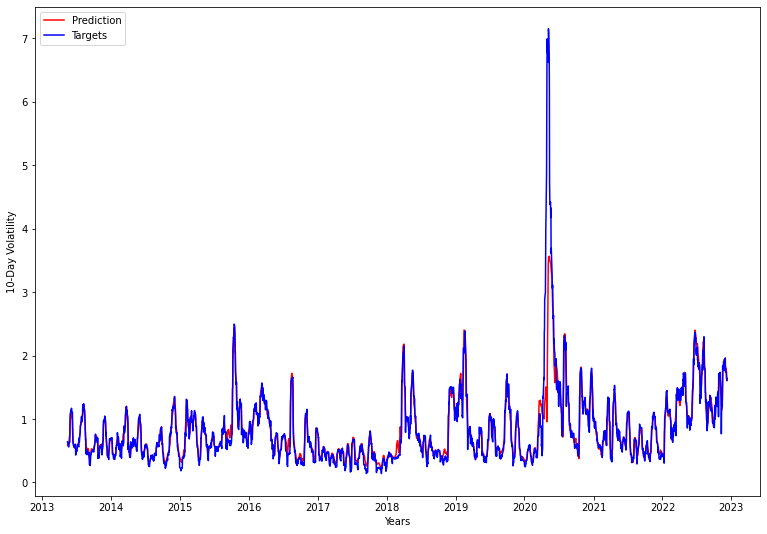

In [ ]:
df = data.copy()
df = df.tail(len(preds))
df.drop(df.columns, inplace=True, axis=1)
df['preds'] = preds

# Generate output
plt.figure(figsize=(13,9))
plt.plot(df.index, preds, label="Prediction", color="red")
plt.plot(df.index, targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

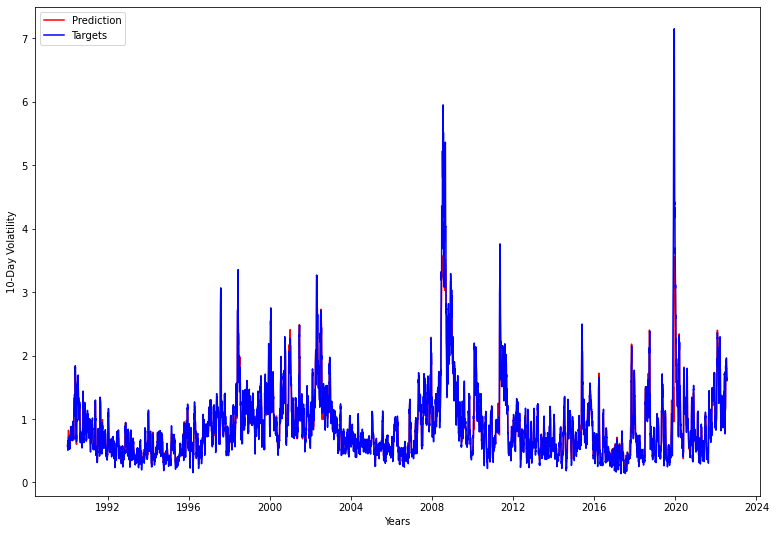

Test loss : 0.05090095


In [ ]:
# Prediction for the entire dataset
data_loader = DataLoaderForVolatilityModeling(dataset, vol_10,batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Make predictions
preds, targets, test_loss = predict(data_loader, model)

# Generate output
plt.figure(figsize=(13,9))
plt.plot(data.index[:len(preds)], preds, label="Prediction", color="red")
plt.plot(data.index[:len(targets)], targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)